In [1]:
import warnings
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

In [3]:
from pre_analysis_class import PreAnalysis
from post_analysis_class import PostAnalysis

In [4]:
pd.options.display.max_columns=None
pd.options.display.max_rows=None
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext autoreload
%autoreload 2

In [5]:
def read(fp):
    df = (pd.read_csv(fp)
             .rename(columns=str.lower)
             .drop('customerid', axis=1)
             .assign(gender=lambda x: pd.Categorical(x['gender']),
                     partner=lambda x: pd.Categorical(x['partner']),
                     seniorcitizen=lambda x: pd.Categorical(x['seniorcitizen']).astype('str'),
                     totalcharges=lambda x: pd.to_numeric(x['totalcharges'], errors='coerce').fillna(0, downcast='infer'),
                     multiplelines=lambda x: pd.Categorical(x['multiplelines']),
                     internetservice=lambda x: pd.Categorical(x['internetservice'])))
    return df

df_raw_data = read('https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_raw_data.head(10)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,Yes
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650,820.500,Yes
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.100,1949.400,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.750,301.900,No
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.800,3046.050,Yes
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.150,3487.950,No


In [6]:
TARGET = 'churn'
FEATURES = df_raw_data.columns.tolist()
FEATURES.remove(TARGET)

y = df_raw_data[TARGET]
X = df_raw_data[FEATURES]

In [7]:
pre_analysis = PreAnalysis(X, y)

In [8]:
pre_analysis.ml_usecase

'binary'

In [9]:
pre_analysis.get_all_summary_stats()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


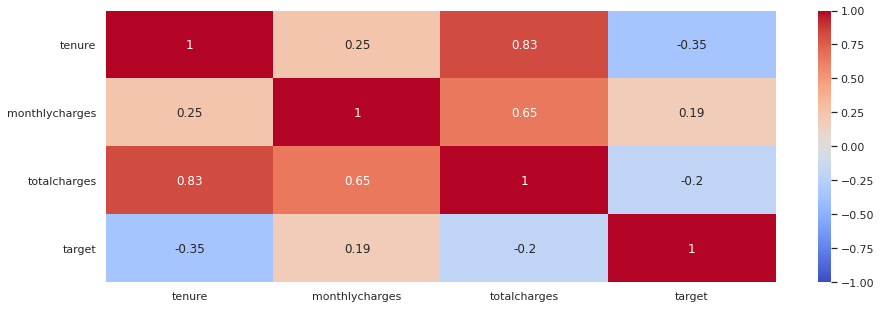

In [10]:
pre_analysis.show_correlation_matrix(with_target=True, remove_duplicate_half=False)

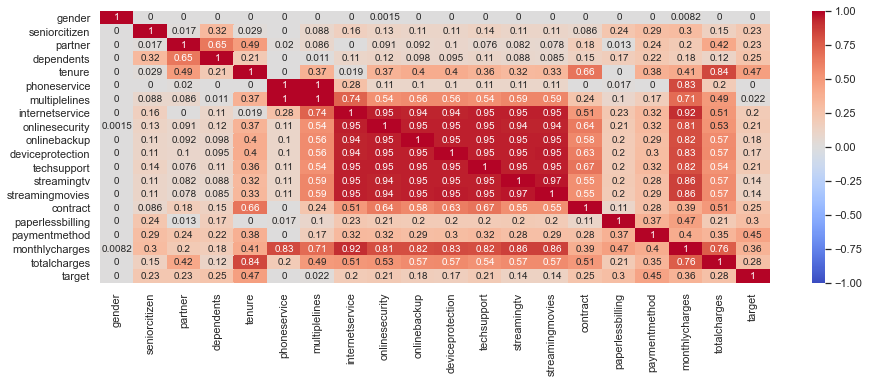

In [44]:
pre_analysis.show_correlation_matrix(correlation_type='phik', with_target=True, remove_duplicate_half=False)

In [12]:
pre_analysis.check_distribution_of_feature(['monthlycharges', 'totalcharges'])

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [14]:
numeric_features = pre_analysis.numerical_columns
categorical_features = pre_analysis.categorical_columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

transformers = []

for feature in numeric_features:
    transformers.append((feature, numeric_transformer, [feature]))
    
for feature in categorical_features:
    transformers.append((feature, categorical_transformer, [feature]))
    

In [15]:
preprocessor = ColumnTransformer(transformers=transformers)

le = LabelEncoder()
yb = le.fit_transform(y)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(learning_rate=0.2,
                                n_estimators=19,
                                subsample=0.8,
                                max_depth=3))
])

X_train, X_test, y_train, y_test = train_test_split(X, yb, test_size=0.2, random_state=42, stratify=y)

clf.fit(X_train, y_train)

print('model score: %.3f' % clf.score(X_test, y_test))

[08:38:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model score: 0.802


In [16]:
pa = PostAnalysis(clf['classifier'], clf['preprocessor'], X_test, y_test)

In [17]:
pa.show_performance()

Output(layout=Layout(margin='0 0 50px 0'))

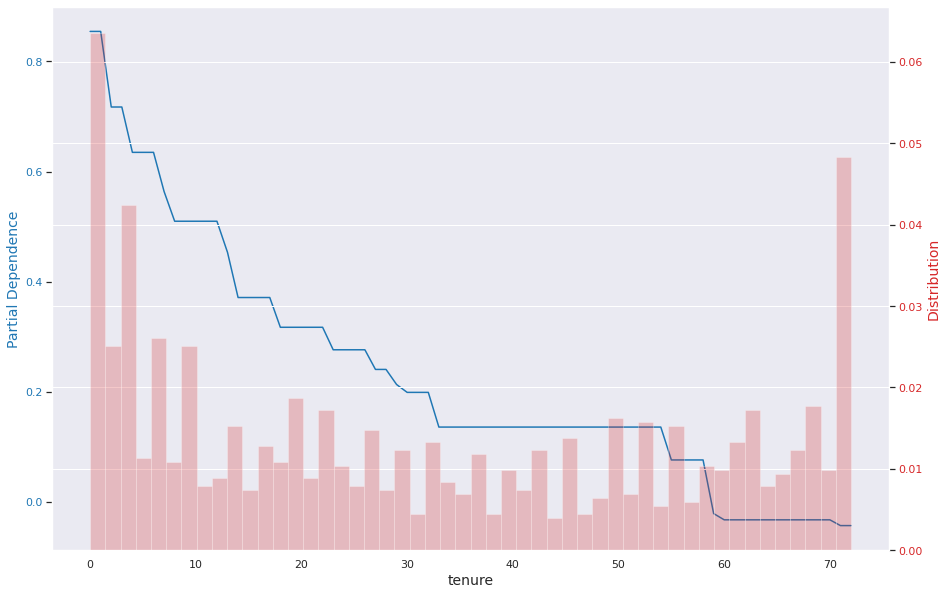

In [18]:
pa.plot_pdp('tenure')

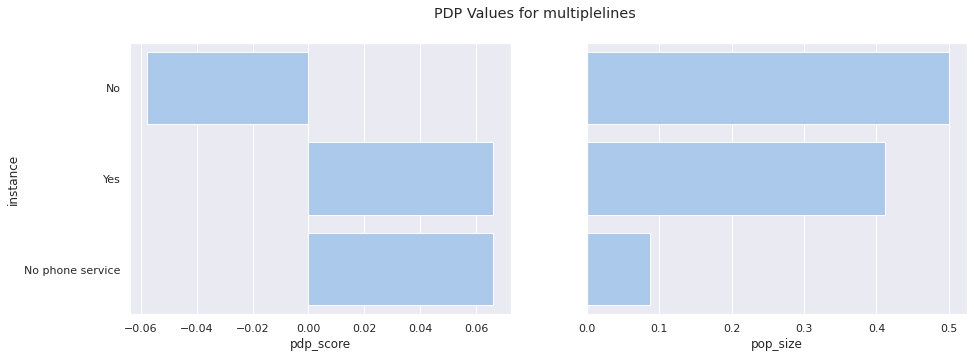

In [19]:
pa._calc_ohe_pdp('multiplelines')
#pa.transformed_features.columns.tolist()

In [20]:
pa.get_subpopulation_report_in_widget('multiplelines')

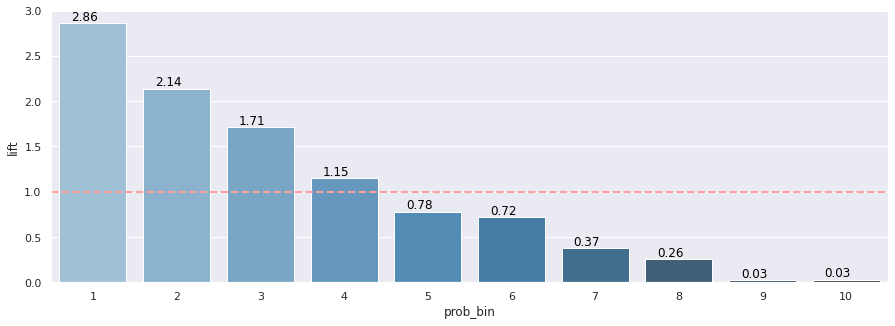

In [21]:
pa.get_lift_per_bin()

In [22]:
pa.get_feature_importance()

In [23]:
from post_production_monitoring import show_drift

In [24]:
show_drift(X_train, X_test)

In [ ]:
import phik
from phik import resources, report

In [ ]:
X_train.phik_matrix()

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
profile = ProfileReport(X_train, title='Pandas Profile Report')

In [ ]:
profile.to_widgets()